# Chapter 9 - Support Vector Machines

[9.3 Support Vector Machines](#9.3-Support-Vector-Machines)
> [9.3.3 An Application to the Heart Disease Data](#9.3.3-An-Application-to-the-Heart-Disease-Data)

[9.6 Lab: Support Vector Machines](#9.6-Lab:-Support-Vector-Machines)
> [9.6.1 Support Vector Classifier](#9.6.1-Support-Vector-Classifier)<br>
> [9.6.2 Support Vector Machine](#9.6.2-Support-Vector-Machine)<br>
> [9.6.3 ROC Curves](#9.6.3-ROC-Curves)<br>
> [9.6.4 SVM with Multiple Classes](#9.6.4-SVM-with-Multiple-Classes)

In [93]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC

import classification_helper

%matplotlib inline
plt.style.use('seaborn-white')

## 9.3 Support Vector Machines

### 9.3.3 An Application to the Heart Disease Data

In [2]:
df_heart = pd.read_csv('Data/Heart.csv', index_col=0).dropna()
for cat_col in ['ChestPain', 'Thal', 'AHD']:
    df_heart[cat_col] = df_heart[cat_col].astype('category')
    print(f'{cat_col}: {df_heart[cat_col].cat.categories.values}')
df_heart.head(3)

ChestPain: ['asymptomatic' 'nonanginal' 'nontypical' 'typical']
Thal: ['fixed' 'normal' 'reversable']
AHD: ['No' 'Yes']


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [3]:
X = pd.get_dummies(df_heart.drop(['AHD'], axis=1), drop_first=True)
y = df_heart.AHD.map({'Yes': 1, 'No': 0})
X.head(3)

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
1,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,1,0,0
2,67,1,160,286,0,2,108,1,1.5,2,3.0,0,0,0,1,0
3,67,1,120,229,0,2,129,1,2.6,2,2.0,0,0,0,0,1


In [4]:
y.head()

1    0
2    1
3    1
4    0
5    0
Name: AHD, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=90)

In [6]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_LDA = lda.predict_proba(X_test)[:,1]
*roc_LDA, _ = roc_curve(y_test, y_pred_LDA)
roc_auc_LDA = auc(*roc_LDA)

In [7]:
# SVC
svc = make_pipeline(StandardScaler(), LinearSVC())
svc.fit(X_train, y_train)
y_pred_SVC = svc.decision_function(X_test)
*roc_SVC, _ = roc_curve(y_test, y_pred_SVC)
roc_auc_SVC = auc(*roc_SVC)

In [8]:
# SVM
gammas = [1e-3, 1e-2, 1e-1]
roc_SVMs = []
roc_auc_SVMs = []
for gamma in gammas:
    svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=gamma))
    svm.fit(X_train, y_train)
    y_pred_SVM = svm.decision_function(X_test)
    *roc_SVM, _ = roc_curve(y_test, y_pred_SVM)
    roc_auc_SVM = auc(*roc_SVM)
    
    roc_SVMs.append(roc_SVM)
    roc_auc_SVMs.append(roc_auc_SVM)

#### FIGURE 9.11

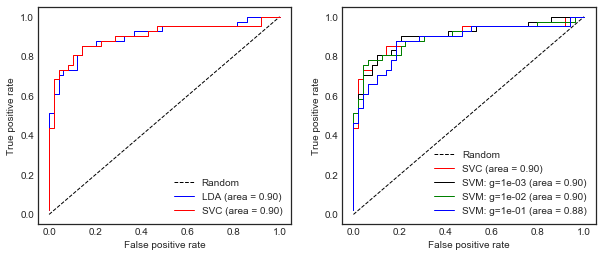

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# LDA vs SVC
ax1.plot(np.linspace(0, 1.0, 100), np.linspace(0, 1.0, 100), color='black', linestyle='--', lw=1, label='Random')
ax1.plot(*roc_LDA, color='blue', lw=1, label=f'LDA (area = {roc_auc_LDA:0.2f})')
ax1.plot(*roc_SVC, color='red', lw=1, label=f'SVC (area = {roc_auc_SVC:0.2f})')
ax1.legend();

# SVC vs SVM
ax2.plot(np.linspace(0, 1.0, 100), np.linspace(0, 1.0, 100), color='black', linestyle='--', lw=1, label='Random')
ax2.plot(*roc_SVC, color='red', lw=1, label=f'SVC (area = {roc_auc_SVC:0.2f})')
for i, color in enumerate(['black', 'green', 'blue']):
    ax2.plot(*roc_SVMs[i], color=color, lw=1, label=f'SVM: g={gammas[i]:1.0e} (area = {roc_auc_SVMs[i]:0.2f})')
ax2.legend();

for ax in [ax1, ax2]:
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')

## 9.6 Lab: Support Vector Machines

### 9.6.1 Support Vector Classifier

In [328]:
# generate random data
X = np.random.normal(size=(20,2))
y = np.concatenate([-1*np.ones((10,)), 1*np.ones((10,))])

In [329]:
# non linearly separable case:
X[y==1] += 1

In [330]:
svc = SVC(kernel='linear', C=100)
svc.fit(X, y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

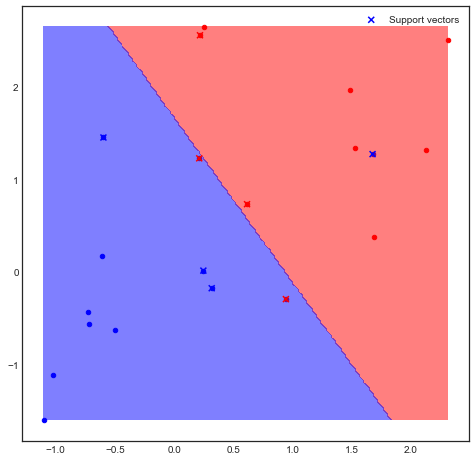

In [331]:
ax = classification_helper.plot_classification(svc, X, (y+1)/2)
support_vecs = svc.support_vectors_
ax.scatter(support_vecs[:, 0], support_vecs[:, 1], marker='x', c=['b' if val==-1 else 'r' for val in y[svc.support_]], label='Support vectors')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-1:], labels[-1:])
plt.show()

In [332]:
len(support_vecs)

8

In [333]:
# Set up possible values of parameters to optimize over
p_grid = {'C': np.logspace(-2, 1, 50)}

clf = SVC(kernel='linear')

# Parameter search and scoring
grid_search = GridSearchCV(estimator=clf, param_grid=p_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)
grid_search.best_params_

{'C': 0.01}

In [334]:
grid_search.best_score_

0.9

Classification Report:
             precision    recall  f1-score   support

       -1.0      0.900     0.900     0.900        10
        1.0      0.900     0.900     0.900        10

avg / total      0.900     0.900     0.900        20

Confusion Matrix:
           Predicted      
                True False
Real True        0.9   0.1
     False       0.1   0.9



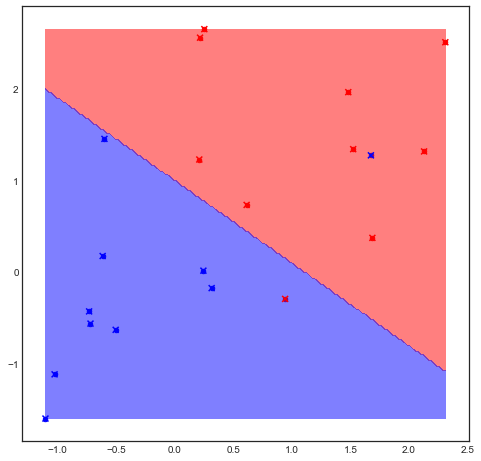

In [335]:
ax = classification_helper.plot_classification(grid_search, X, (y+1)/2)
support_vecs = grid_search.best_estimator_.support_vectors_
ax.scatter(support_vecs[:, 0], support_vecs[:, 1], marker='x', c=['b' if val==-1 else 'r' for val in y[grid_search.best_estimator_.support_]])
handles, labels = ax.get_legend_handles_labels()

classification_helper.print_classification_statistics(grid_search, X, y)

In [336]:
# non linearly separable case:
X[y==1] += 1

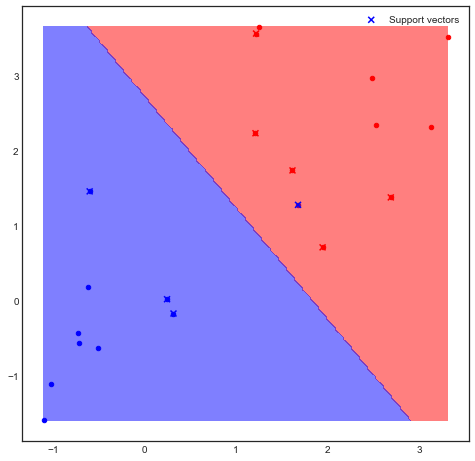

Classification Report:
             precision    recall  f1-score   support

       -1.0      1.000     0.900     0.947        10
        1.0      0.909     1.000     0.952        10

avg / total      0.955     0.950     0.950        20

Confusion Matrix:
           Predicted      
                True False
Real True        0.9   0.1
     False       0.0   1.0



In [337]:
svc = SVC(kernel='linear', C=0.1)
svc.fit(X, y)

ax = classification_helper.plot_classification(svc, X, (y+1)/2)
support_vecs = svc.support_vectors_
ax.scatter(support_vecs[:, 0], support_vecs[:, 1], marker='x', c=['b' if val==-1 else 'r' for val in y[svc.support_]], label='Support vectors')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-1:], labels[-1:])
plt.show()

classification_helper.print_classification_statistics(svc, X, y)

### 9.6.2 Support Vector Machine

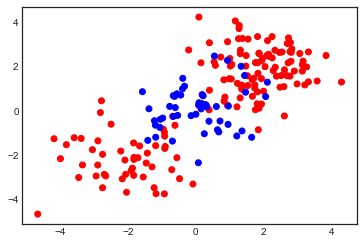

In [364]:
# generate random data, non linearly separable
X = np.random.normal(size=(200,2))
X[:100] += 2
X[100:150] -= 2
y = np.concatenate([1*np.ones((150,)), np.zeros((50,))])
plt.scatter(X[:, 0], X[:, 1], c=['r' if val==1 else 'b' for val in y]);

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100)

In [362]:
p_grid = {'svc__C': np.logspace(-3, 0.1, 50),
          'svc__gamma': np.linspace(0.1, 10, 20)}

svm = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
grid_search = GridSearchCV(estimator=svm, param_grid=p_grid, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'svc__C': 0.7029732115325468, 'svc__gamma': 0.6210526315789474}

Classification Report:
             precision    recall  f1-score   support

        0.0      0.947     0.643     0.766        28
        1.0      0.877     0.986     0.928        72

avg / total      0.896     0.890     0.883       100

Confusion Matrix:
           Predicted          
                True     False
Real True   0.642857  0.357143
     False  0.013889  0.986111

% of miscassified samples:  11.0 %


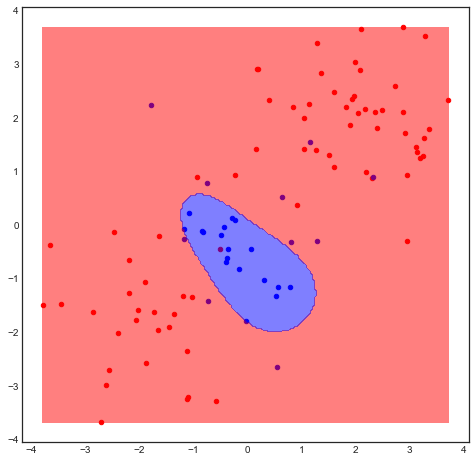

In [372]:
best_svm = grid_search.best_estimator_.named_steps['svc']

classification_helper.plot_classification(best_svm, X_test, y_test)
classification_helper.print_classification_statistics(best_svm, X_test, y_test)
y_pred = best_svm.predict(X_test)
print('% of miscassified samples: ', 100-accuracy_score(y_test, y_pred)*100, '%')

### 9.6.3 ROC Curves

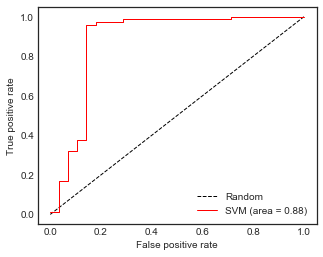

In [381]:
y_pred_SVM = best_svm.decision_function(X_test)
*roc_SVM, _ = roc_curve(y_test, y_pred_SVM)
roc_auc_SVM = auc(*roc_SVM)

fig, ax = plt.subplots(1, 1, figsize=(5,4))

# LDA vs SVC
ax.plot(np.linspace(0, 1.0, 100), np.linspace(0, 1.0, 100), color='black', linestyle='--', lw=1, label='Random')
ax.plot(*roc_SVM, color='red', lw=1, label=f'SVM (area = {roc_auc_SVM:0.2f})')
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.legend();

### 9.6.4 SVM with Multiple Classes

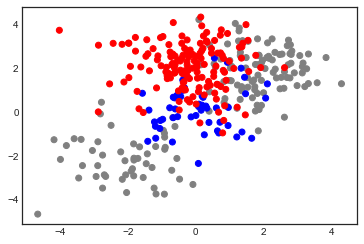

In [419]:
# add a third class
X = np.concatenate([X, np.random.normal(loc=(0, 2), size=(50,2))])
y = np.concatenate([y, 2*np.ones((50,))])
plt.scatter(X[:, 0], X[:, 1], c=['grey' if val==1 else ('b' if val==0 else 'r') for val in y]);

Classification Report:
             precision    recall  f1-score   support

        0.0      0.625     0.600     0.612        50
        1.0      0.849     0.827     0.838       150
        2.0      0.808     0.840     0.824       150

avg / total      0.799     0.800     0.799       350

Confusion Matrix:
       Predicted                
               0         1     2
Real 0  0.600000  0.160000  0.24
     1  0.053333  0.826667  0.12
     2  0.066667  0.093333  0.84

% of miscassified samples: 20.00%


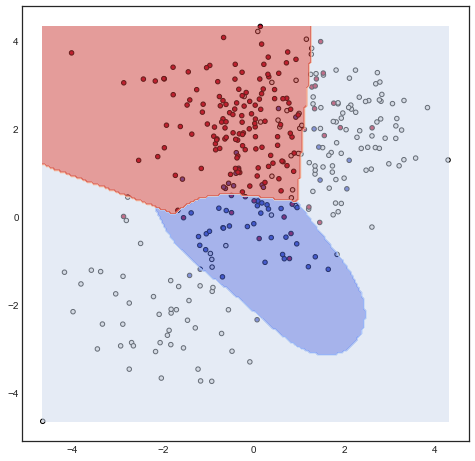

In [420]:
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', decision_function_shape='ovo'))
svm.fit(X, y)

classification_helper.plot_classification(svm, X, y)
classification_helper.print_classification_statistics(svm, X, y)
y_pred = svm.predict(X)
print(f'% of miscassified samples: {100-accuracy_score(y, y_pred)*100:.2f}%')

In [421]:
importlib.reload(classification_helper)

<module 'classification_helper' from 'C:\\Users\\villanueva\\Data Science\\Intro Statistical Learning with R\\ISLR_Python\\classification_helper.py'>